In [18]:
# imports
import sys  
sys.path.insert(0, '../../../TwitterCoordinatedInorganicAgents')

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel
from transformers import AutoTokenizer
import numpy as np
from tweetcore.tasks.postgres_target import download_data
from tweetcore.tasks.classification_task.utils import make_report  
from data_builders.tasks import collapse_embeddings
import credentials_refactor
import global_settings as gs
import gc

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# model utils
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Getting data ready

In [2]:
# data
conf = credentials_refactor.return_credentials()
data = download_data.pandas_df_from_postgre_query(configuration = conf ,
                                                  query = '''
                                                          select *
                                                          from redacted_tables.features_user_classification
                                                          limit 10000
                                                          ''')

# User-based classifier

## Getting data ready

In [3]:
user_based_features = [i for i in data.columns if 'uuu' in i]

In [4]:
df_user = data[user_based_features + ["target"]].copy()

In [5]:
df_user.fillna(-1,inplace=True)


In [6]:
cast_to_int = ['uuu_year_joined', 'uuu_month_joined', 'uuu_day_of_month_joined', 'uuu_day_of_week_joined', 'uuu_hour_joined']
for i in cast_to_int:
    df_user.loc[:,i] = df_user[i].astype(int)

In [7]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   uuu_year_joined                        10000 non-null  int32  
 1   uuu_month_joined                       10000 non-null  int32  
 2   uuu_day_of_month_joined                10000 non-null  int32  
 3   uuu_day_of_week_joined                 10000 non-null  int32  
 4   uuu_joined_weekend                     10000 non-null  int64  
 5   uuu_hour_joined                        10000 non-null  int32  
 6   uuu_username_length                    10000 non-null  int64  
 7   uuu_fraction_numbers_username          10000 non-null  float64
 8   uuu_fraction_emojis_username           10000 non-null  float64
 9   uuu_fraction_capital_letters_username  10000 non-null  float64
 10  uuu_fraction_special_char_username     10000 non-null  float64
 11  uuu

## Benchmarking

In [8]:
X = df_user.drop(columns="target").copy()
y = df_user.target.copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                     X, 
                                                     y, 
                                                     test_size=0.35, 
                                                     random_state=12
                                                    )

In [11]:
# benchmark

rf = RandomForestClassifier()
xgb = XGBClassifier()
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
all_models = {"RandomForest":rf,"XGBoost":xgb}

for name, model in zip(all_models.keys(),all_models.values()):
    cv_results = cross_validate(model, 
                            X_train, 
                            y_train, 
                            cv=5,
                            scoring=fpointfive_scorer)
    print(name + " with mean f0.5 over 5 folds of: " + str(round(np.mean(cv_results["test_score"]),4)) + " and sigma accross test metrics of: " + str(round(np.std(cv_results["test_score"]),4)))

RandomForest with mean f0.5 over 5 folds of: 0.3873 and sigma accross test metrics of: 0.0032
XGBoost with mean f0.5 over 5 folds of: 0.4123 and sigma accross test metrics of: 0.0023


## Balancing classes

In [9]:
ideal = len(y[y==0])/len(y[y==1])
print(ideal)

5.666666666666667


In [21]:
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    xgb = XGBClassifier(
                        eval_metric='auc', 
                        scale_pos_weight=scaling
                        )
    xgb.fit(X_train, y_train)

array([0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1, 5.6, 6.1,
       6.6, 7.1, 7.6, 8.1, 8.6, 9.1])

In [10]:
xgb = XGBClassifier(eval_metric='auc', scale_pos_weight=6)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

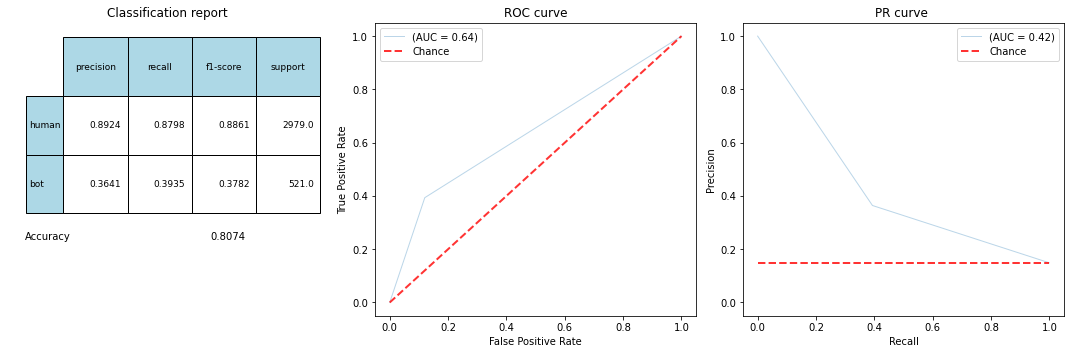

In [21]:
make_report(model = xgb,
            y_test = y_test, 
            x_test = X_test,  
            include = ['class_report', 'roc', 'pr'], 
            pad=1,
            scale=5)

In [12]:
xgb

NameError: name 'xgb' is not defined

In [17]:
predicted = xgb.predict(X_test)
print(classification_report(y_test,predicted,output_dict=True))

NameError: name 'output_dict' is not defined

In [20]:
print(classification_report(y_test,predicted,output_dict=False))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2988
           1       0.45      0.42      0.43       512

    accuracy                           0.84      3500
   macro avg       0.68      0.67      0.67      3500
weighted avg       0.84      0.84      0.84      3500



In [109]:
report = classification_report(y_test,predicted,output_dict=True)
df_report = pd.DataFrame(data=report)[['0','1']].T
df_report

,precision,recall,f1-score,support
0,0.901753,0.912316,0.907004,2988.0
1,0.450734,0.419922,0.434783,512.0


In [105]:
classification_report(y_test,predicted,output_dict=True)

{'0': {'precision': 0.9017532252729077,
  'recall': 0.9123159303882196,
  'f1-score': 0.9070038263184163,
  'support': 2988},
 '1': {'precision': 0.45073375262054505,
  'recall': 0.419921875,
  'f1-score': 0.43478260869565216,
  'support': 512},
 'accuracy': 0.8402857142857143,
 'macro avg': {'precision': 0.6762434889467264,
  'recall': 0.6661189026941098,
  'f1-score': 0.6708932175070342,
  'support': 3500},
 'weighted avg': {'precision': 0.8357755195591907,
  'recall': 0.8402857142857143,
  'f1-score': 0.8379246081976005,
  'support': 3500}}

In [111]:
acc = round(report['accuracy'],4)

In [87]:
df_report.index#.map(lambda x: 'bot' if x==1 else 'human')

Index(['0', '1'], dtype='object')

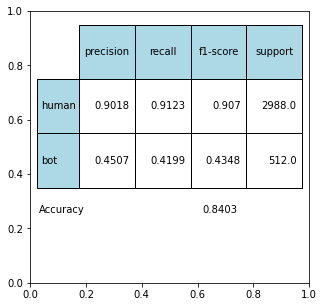

In [137]:
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
ax.table(cellText=np.round(df_report.values,4), 
         colLabels=df_report.columns, 
         rowLabels=df_report.index.map(lambda x: 'bot' if x=='1' else 'human'),
         colWidths = [0.2]*4,
         bbox = [0.175, 0.35, 0.8, 0.6],
         edges='closed',
         colColours = ['lightblue']*4,
         rowColours = ['lightblue']*2,
         fontsize=1000)

ax.table(cellText=[['','',acc]], 
         rowLabels=['Accuracy'],
         colWidths = [0.2]*3,
         bbox = [0.21, 0.17, 0.55, 0.2],
         edges='open',
         rowColours = ['lightblue']*2,
         fontsize=1000)

In [133]:
report

{'0': {'precision': 0.9017532252729077,
  'recall': 0.9123159303882196,
  'f1-score': 0.9070038263184163,
  'support': 2988},
 '1': {'precision': 0.45073375262054505,
  'recall': 0.419921875,
  'f1-score': 0.43478260869565216,
  'support': 512},
 'accuracy': 0.8402857142857143,
 'macro avg': {'precision': 0.6762434889467264,
  'recall': 0.6661189026941098,
  'f1-score': 0.6708932175070342,
  'support': 3500},
 'weighted avg': {'precision': 0.8357755195591907,
  'recall': 0.8402857142857143,
  'f1-score': 0.8379246081976005,
  'support': 3500}}

In [ ]:
# ROC curve
model=xgb
y_true = y_test
y_pre = model.predict(X_test)
ax1=plt.subplot(111)
fpr, tpr, thresholds = roc_curve(y_true, y_pre)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, lw=1, alpha=0.3,label='(AUC = %0.2f)'%roc_auc)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC curve ')
ax1.legend(loc='best')
    

In [ ]:
# PR curve
model=xgb
y_true = y_test
y_pre = model.predict(X_test)
ax1=plt.subplot(111)
precision, recall, thresholds = precision_recall_curve(y_true, y_pre)
pr_auc = auc(recall, precision)
ax1.plot(recall, precision, lw=1, alpha=0.3,label='(AUC = %0.2f)'%pr_auc)
ax1.plot([0, 1], [np.mean(y), np.mean(y)], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_ylabel('Precision')
ax1.set_xlabel('Recall')
ax1.set_title('PR curve ')
ax1.legend(loc='best')
    

In [ ]:
del xgb, sc
sc = StandardScaler(with_mean=True)
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

In [ ]:
predicted = xgb.predict(X_test_scaled)
print(classification_report(y_test,predicted))

In [ ]:
ftwo_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)

In [ ]:
# weighting the classes to account for imbalancing
rf = RandomForestClassifier()

In [ ]:
n_samples / (n_classes * np.bincount(y))

# PCA to reduce dimentionality 

In [ ]:
# scale before PCA
# try with_mean = False
sc = StandardScaler(with_mean=True)
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)
for j_features in [34, 24, 14, 4]:
    xgb = XGBClassifier()
    pca = PCA(n_components = j_features)
    X_train_scaled_pca = pca.fit_transform(X_train_scaled)
    xgb.fit(X_train_scaled_pca, y_train)
    X_test_scaled_transformed = pca.transform(X_test_scaled)
    predicted = xgb.predict(X_test_scaled_transformed)
    del xgb, pca
    print(j_features)
    print(classification_report(y_test,predicted))

In [ ]:
X_test_scaled = sc.transform(X_test)

In [ ]:
predicted = xgb.predict(X_test_scaled)
classification_report(y_Tes)

In [ ]:
print(classification_report(y_test,predicted))